#Globals

In [1]:
global_var = {
    # Data
    'mesh_data_path' : "/content/mesh_data",
    'mesh_data_url' : "https://drive.google.com/drive/folders/1SRWjFd98IfoWbOm20_RnB90DKem6RYaY?usp=sharing",

    # Networks
    'hidden_dim' : 256,
    'print_debug' : True,
    'verts_dim' : 3,
    'emb_net_depth' : 4,
    'disp_dim' : 1,
    'disp_net_depth' : 2,
    'norm_ratio' : 0.1,

    # Rendering
    'rendered_items' : 4
}

In [2]:
!pip install gdown open3d --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00


#Imports

In [14]:
import copy
import gdown
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import os
import plotly.graph_objects as go
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import transforms
from tqdm import trange
from tqdm import tqdm

In [4]:
if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
    # We try to install PyTorch3D via a released wheel.
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install fvcore iopath
    !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
else:
    # We try to install PyTorch3D from source.
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 869.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=8fdd570ff055570a0bebb7e1efa16590e0e0df1b68de85bcb72358f78da5917a
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=18e3113856972264474296b6ba5964cd93fa84baa6bb440e8fb2748416b84c5f
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 153.3 MB/s eta 0:00:00


In [5]:
from pytorch3d.io import load_objs_as_meshes, load_obj # Util function for loading meshes
from pytorch3d.structures import Meshes # Data structures and functions for rendering
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

In [6]:
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Dataset

## Data download

In [7]:
if not os.path.exists(global_var['mesh_data_path']):
    print("[LOG] Starting dataset download...")
    gdown.download_folder(url = global_var['mesh_data_url'],
        output = global_var['mesh_data_path'],
        quiet=True)
    print("[LOG] Dataset download ended!")

else:
    print("[LOG] Mesh dataset already downloaded!")

[LOG] Starting dataset download...
[LOG] Dataset download ended!


## Shape visualization

In [33]:
def get_dataset_meshes(dataset_path):
    meshes_paths = []
    meshes = []

    for current_dir, _, files in os.walk(dataset_path):
        for elem in files:
            if ".obj" in elem:
                mesh_path = os.path.join(current_dir, elem)
                meshes_paths.append(mesh_path)

    meshes_paths.sort()

    for m in meshes_paths:
        meshes.append(load_objs_as_meshes([m],device=device))

    return meshes_paths, meshes

In [34]:
def mesh_visualization(obj_file_path):
    mesh = o3d.io.read_triangle_mesh(obj_file_path)

    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)

    fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=True),
                yaxis=dict(visible=True),
                zaxis=dict(visible=True)
            )
        )
    )

    return fig

In [39]:
meshes_paths, meshes = get_dataset_meshes(global_var['mesh_data_path'])
random_mesh_idx = random.randint(0,len(meshes_paths)-1)
# random_mesh_path = meshes_paths[random_mesh_idx]
# random_mesh = meshes[random_mesh_idx]
random_mesh_path = meshes_paths[1]
random_mesh = meshes[1]

mesh_fig = mesh_visualization(random_mesh_path)
mesh_fig.show()

## Rendered shape visualization

In [40]:
def rendered_shape(mesh, device, items=3):
    distances = [round(random.uniform(1, 3),2) for _ in range(items)] # Controllare valori default da cui selezionare quelli random
    elevations = [random.randint(0, 359) for _ in range(items)] # This is the angle between the vector from the object to the camera, and the horizontal plane y = 0 (xz-plane).
    angles = [random.randint(0, 359) for _ in range(items)] # The vector from the object to the camera is projected onto a horizontal plane y = 0. azim is the angle between the projected vector and a reference vector at (0, 0, 1) on the reference plane (the horizontal plane).
    rendered_images = []

    for idx in tqdm(range(items), leave=True):
        print(f"[LOG] Computing render for distance {distances[idx]}, elevation {elevations[idx]}, angle {angles[idx]}")
        R, T = look_at_view_transform(
            distances[idx],
            elevations[idx],
            angles[idx],
            degrees=True)

        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

        raster_settings = RasterizationSettings(
            image_size=512,
            blur_radius=0.0,
            faces_per_pixel=1,
        )

        lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings
            ),
            shader=SoftPhongShader(
                device=device,
                cameras=cameras,
                lights=lights
            )
        )

        rendered_images.append(renderer(mesh))

    return distances, elevations, angles, rendered_images

In [41]:
distances, elevations, angles, demo_rendered_images = rendered_shape(random_mesh,device,items=4)

100%|██████████| 4/4 [00:00<00:00, 33.15it/s]

[LOG] Computing render for distance 1.92, elevation 88, angle 196
[LOG] Computing render for distance 2.26, elevation 286, angle 131
[LOG] Computing render for distance 1.28, elevation 97, angle 284
[LOG] Computing render for distance 2.53, elevation 172, angle 89


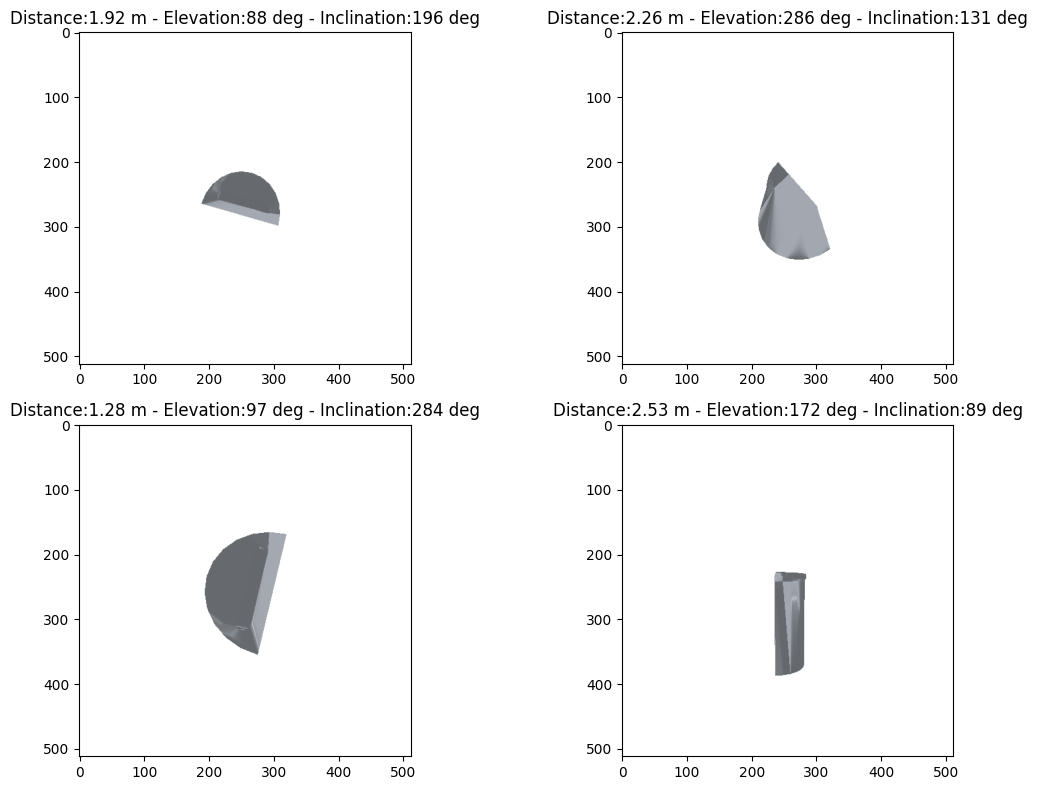

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(demo_rendered_images[i][0, ..., :3].cpu().numpy())
    ax.set_title(f"Distance:{distances[i]} m - Elevation:{elevations[i]} deg - Inclination:{angles[i]} deg")

plt.tight_layout()
plt.show()

## Input features
The workflow starts with extracting the vertices of the meshes related to the 3D shape we want to deform. These vertices will be the input to the neural network that will approximate the displacement vector for the deformation. From this point until the end of the workflow, a fixed 3D shape will be considered for the sake of clarity of the steps.

<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/082ad323538acf40a913a9de7478f81e8caff09f/pics/mesh_vers.png?token=GHSAT0AAAAAACKX5CENWWY3O7WUFMTECKI2ZMP6YTA" alt="Mesh_verts" />
</center>

In [43]:
def get_mesh(obj_path):
    verts, faces_idxs, _ = load_obj(obj_path)
    faces = faces_idxs.verts_idx

    # Initialize each vertex to be white in color since this feature isn't required in our project
    verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
    textures = TexturesVertex(verts_features=verts_rgb.to(device))

    mesh = Meshes(
        verts=[verts.to(device)],
        faces=[faces.to(device)],
        textures=textures
    )

    return mesh

In [44]:
sample_mesh_path = meshes_paths[9]
sample_mesh = get_mesh(sample_mesh_path)
sample_mesh_shape = sample_mesh.verts_list()[0].shape
vertices_num = sample_mesh_shape[0]
vertices_dim = sample_mesh_shape[1]
print(f"[LOG] 3D shape has {vertices_num} vertices with dimension {vertices_dim}")

mesh_fig = plot_scene({
    "Sample mesh": {
        "mesh": sample_mesh
    }
})
mesh_fig.show()

[LOG] 3D shape has 48 vertices with dimension 3


## Positional encoding
Positional encoding is important in the context of mesh vertices of a 3D shape because the neural network treats vertices as tokens, without any information about their relative position in the mesh. Without some form of position information, the model may have difficulty capturing the spatial relationships between vertices, which are critical in 3D representations. This approach can be learned, simply by leveraging a fully connected layer. By doing so, the input vertices will be processed in such a way as to retain their spatial info.

<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/pos_encd.png?token=GHSAT0AAAAAACKX5CEMDWTEUKY2EX2QT35GZMT465Q" alt="Pos_enc" />
</center>

In [45]:
class PositionalEncodingNet(nn.Module):
    def __init__(self, verts_dim=3, hidden_dim=256, debug=False):
        super(PositionalEncodingNet, self).__init__()

        layers = []
        layers.append(nn.Linear(verts_dim,hidden_dim))
        layers.append(nn.ReLU())

        self.debug = debug
        self.pos_net = nn.ModuleList(layers)

        if self.debug:
            print("\n[LOG] Positional Encoding network")
            print(self.pos_net)

    def forward(self, x):
        print(f"\n[LOG] ************* {self._get_name()} forward: START *************") if self.debug else None
        print(f"\n[LOG] Input shape: {x.shape}") if self.debug else None

        for layer in self.pos_net:
            x = layer(x)

        print(f"[LOG] Output shape: {x.shape}") if self.debug else None
        print(f"\n[LOG] ************* {self._get_name()} forward: END *************") if self.debug else None

        return x

In [47]:
sample_mesh_verts = sample_mesh.verts_list()[0]
sample_mesh_verts_shape = sample_mesh_verts.shape
print(f"[LOG] Mesh vertices are in a {type(sample_mesh_verts)} of shape {sample_mesh_verts_shape}")

pos_encoder = PositionalEncodingNet(
    verts_dim = global_var['verts_dim'],
    hidden_dim = global_var['hidden_dim'],
    debug = global_var['print_debug']).to(device)

positioned_mesh_verts = pos_encoder(sample_mesh_verts)

[LOG] Mesh vertices are in a <class 'torch.Tensor'> of shape torch.Size([48, 3])

[LOG] Positional Encoding network
ModuleList(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
)

[LOG] ************* PositionalEncodingNet forward: START *************

[LOG] Input shape: torch.Size([48, 3])
[LOG] Output shape: torch.Size([48, 256])

[LOG] ************* PositionalEncodingNet forward: END *************


In [48]:
input_mesh_verts = sample_mesh.verts_list()[0]
truth_mesh_verts = positioned_mesh_verts

pos_enc_model = pos_encoder = PositionalEncodingNet(
    verts_dim = global_var['verts_dim'],
    hidden_dim = global_var['hidden_dim'],
    debug = False)
pos_enc_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(pos_enc_model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.02)

iters = 1000
with trange(iters,desc="Train", unit="", position=0, leave=True) as pbar:
    for iter in pbar:
        pos_enc_model.train()

        # Load data
        inputs = input_mesh_verts.to(device)
        targets = truth_mesh_verts.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = pos_enc_model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward
        loss.backward(retain_graph=True)
        optimizer.step()

        # Log
        pbar.set_postfix(loss=loss.item())

Train: 100%|██████████| 1000/1000 [00:03<00:00, 258.91/s, loss=0.0262]


## Embedded vertices
After including the spatial info relative to the vertices of the mesh, the next step in the workflow sees a small neural network embedding the aforementioned element.

<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/verts_emb.png?token=GHSAT0AAAAAACKX5CEMDWTEUKY2EX2QT35GZMT465Q" alt="Verts_emb" />
</center>

In [49]:
class EmbeddingNet(nn.Module):
    def __init__(self, hidden_dim=256, depth=4, debug=False):
        super(EmbeddingNet, self).__init__()

        layers = []
        for i in range(depth):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())


        self.debug = debug
        self.emb_net = nn.ModuleList(layers)

        if self.debug:
            print("\n[LOG] Embedding network")
            print(self.emb_net)

    def forward(self, x):
        print(f"\n[LOG] ************* {self._get_name()} forward: START *************") if self.debug else None
        print(f"\n[LOG] Input shape: {x.shape}") if self.debug else None

        for layer in self.emb_net:
            x = layer(x)

        print(f"[LOG] Output shape: {x.shape}") if self.debug else None
        print(f"\n[LOG] ************* {self._get_name()} forward: END *************") if self.debug else None

        return x

In [50]:
embed_net = EmbeddingNet(
    hidden_dim = global_var['hidden_dim'],
    depth = global_var['emb_net_depth'],
    debug = global_var['print_debug']).to(device)

embedded_mesh_verts = embed_net(positioned_mesh_verts)


[LOG] Embedding network
ModuleList(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
)

[LOG] ************* EmbeddingNet forward: START *************

[LOG] Input shape: torch.Size([48, 256])
[LOG] Output shape: torch.Size([48, 256])

[LOG] ************* EmbeddingNet forward: END *************


In [46]:
input_mesh_verts = positioned_mesh_verts
truth_mesh_verts = embedded_mesh_verts

embed_net_model = EmbeddingNet(
    hidden_dim = global_var['hidden_dim'],
    depth = global_var['emb_net_depth'],
    debug = False)
embed_net_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(embed_net_model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.02)

iters = 1000
with trange(iters,desc="Train", unit="", position=0, leave=True) as pbar:
    for iter in pbar:
        embed_net_model.train()

        # Load data
        inputs = input_mesh_verts.to(device)
        targets = truth_mesh_verts.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = embed_net_model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward
        loss.backward(retain_graph=True)
        optimizer.step()

        # Log
        pbar.set_postfix(loss=loss.item())

Train: 100%|██████████| 1000/1000 [00:15<00:00, 65.43/s, loss=0.000265]


## Displacement prediction

The network's output is indicative of a displacement along the vertex normal. To mitigate any alterations to the content, strict control is exercised over the vertex normal, ensuring it remains confined within the specified range of $(-0.1, 0.1)$. This measure aims to preserve the original content by restricting the extent of vertex normal adjustments

<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/verts_disp.png?token=GHSAT0AAAAAACKX5CEMPMVC2BOZO4XJRXVWZMQEPXA" alt="Verts_disp" />
</center>

In [51]:
class DisplacementNet(nn.Module):
    def __init__(self, disp_dim=1, hidden_dim=256, disp_depth=2, norm_ratio = 0.1, debug=False):
        super(DisplacementNet, self).__init__()

        layers = []
        for i in range(disp_depth):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, disp_dim))

        self.debug = debug
        self.norm_ratio = norm_ratio
        self.disp_net = nn.ModuleList(layers)

        if self.debug:
            print("\n[LOG] Displacement network")
            print(self.disp_net)

    def forward(self, x):
        print(f"\n[LOG] ************* {self._get_name()} forward: START *************") if self.debug else None
        print(f"\n[LOG] Input shape: {x.shape}") if self.debug else None

        for layer in self.disp_net:
            x = layer(x)
        x = F.tanh(x) * self.norm_ratio

        print(f"[LOG] Output shape: {x.shape}") if self.debug else None
        print(f"\n[LOG] ************* {self._get_name()} forward: END *************") if self.debug else None

        return x

In [52]:
disp_net = DisplacementNet(
    disp_dim = global_var['disp_dim'],
    hidden_dim = global_var['hidden_dim'],
    disp_depth = global_var['disp_net_depth'],
    norm_ratio = global_var['norm_ratio'],
    debug = global_var['print_debug']).to(device)

displaced_mesh_verts = disp_net(embedded_mesh_verts)


[LOG] Displacement network
ModuleList(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)

[LOG] ************* DisplacementNet forward: START *************

[LOG] Input shape: torch.Size([48, 256])
[LOG] Output shape: torch.Size([48, 1])

[LOG] ************* DisplacementNet forward: END *************


In [49]:
input_mesh_verts = embedded_mesh_verts
truth_mesh_verts = displaced_mesh_verts

disp_net_model = DisplacementNet(
    disp_dim = global_var['disp_dim'],
    hidden_dim = global_var['hidden_dim'],
    disp_depth = global_var['disp_net_depth'],
    norm_ratio = global_var['norm_ratio'],
    debug = False)
disp_net_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(disp_net_model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.02)

iters = 1000
with trange(iters,desc="Train", unit="", position=0, leave=True) as pbar:
    for iter in pbar:
        disp_net_model.train()

        # Load data
        inputs = input_mesh_verts.to(device)
        targets = truth_mesh_verts.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = disp_net_model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward
        loss.backward(retain_graph=True)
        optimizer.step()

        # Log
        pbar.set_postfix(loss=loss.item())

Train: 100%|██████████| 1000/1000 [00:11<00:00, 83.62/s, loss=5.89e-11]


## Neural Style Field
The Neural Style Field (NSF) is a neural network designed to learn the mapping of mesh vertices, representing the points on its surface, to displacements along the normal direction. This block is essentially a composition of the previous three functional blocks.
<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/nsf.png?token=GHSAT0AAAAAACKX5CEM5W6VOTRNQIKEGPSIZMQF4KA" alt="nsf" />
</center>

In [53]:
class NeuralStyleField(nn.Module):
    def __init__(self, verts_dim=3, hidden_dim=256, depth=4, disp_dim=1, disp_depth=2, norm_ratio=0.1, debug=False):
        super(NeuralStyleField, self).__init__()

        layers = []
        layers.append(PositionalEncodingNet(verts_dim,hidden_dim,debug=False))
        layers.append(EmbeddingNet(hidden_dim,depth,debug=False))
        layers.append(DisplacementNet(disp_dim,hidden_dim,disp_depth,debug=False))

        self.debug = debug
        self.nsf_net = nn.ModuleList(layers)

        if self.debug:
            print("\n[LOG] Neural Style Field network")
            print(self.nsf_net)

    def forward(self, x):
        print(f"\n[LOG] ************* {self._get_name()} forward: START *************") if self.debug else None
        print(f"\n[LOG] Input shape: {x.shape}") if self.debug else None

        for layer in self.nsf_net:
            print("----------") if self.debug else None
            print(f"[LOG] \t{layer._get_name()} input shape: {x.shape}") if self.debug else None
            x = layer(x)
            print(f"[LOG] \t{layer._get_name()} output shape: {x.shape}") if self.debug else None
            print("----------") if self.debug else None

        print(f"[LOG] Output shape: {x.shape}") if self.debug else None
        print(f"\n[LOG] ************* {self._get_name()} forward: END *************") if self.debug else None

        return x

In [54]:
nsf = NeuralStyleField(
    verts_dim = global_var['verts_dim'],
    hidden_dim = global_var['hidden_dim'],
    depth = global_var['emb_net_depth'],
    disp_dim = global_var['disp_dim'],
    disp_depth = global_var['disp_net_depth'],
    norm_ratio = global_var['norm_ratio'],
    debug = global_var['print_debug']
).to(device)
predicted_displacement = nsf(sample_mesh_verts)


[LOG] Neural Style Field network
ModuleList(
  (0): PositionalEncodingNet(
    (pos_net): ModuleList(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (1): EmbeddingNet(
    (emb_net): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): ReLU()
    )
  )
  (2): DisplacementNet(
    (disp_net): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

[LOG] ************* NeuralStyleField forward: START *************

[LOG] Input shape: torch.Size([48, 3])
----------
[LOG] 	Positi

In [52]:
input_mesh_verts = sample_mesh_verts
truth_mesh_verts = predicted_displacement

nsf_model = NeuralStyleField(
    verts_dim = global_var['verts_dim'],
    hidden_dim = global_var['hidden_dim'],
    depth = global_var['emb_net_depth'],
    disp_dim = global_var['disp_dim'],
    disp_depth = global_var['disp_net_depth'],
    norm_ratio = global_var['norm_ratio'],
    debug = False)
nsf_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(nsf_model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.02)

iters = 1000
with trange(iters,desc="Train", unit="", position=0, leave=True) as pbar:
    for iter in pbar:
        nsf_model.train()

        # Load data
        inputs = input_mesh_verts.to(device)
        targets = truth_mesh_verts.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = nsf_model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward
        loss.backward(retain_graph=True)
        optimizer.step()

        # Log
        pbar.set_postfix(loss=loss.item())

Train: 100%|██████████| 1000/1000 [00:27<00:00, 36.54/s, loss=6.46e-12]


## Mesh updating
The next step consists in summing up the input mesh with the output of the Neural Style Field (i.e. the predicted displacement)

<center>
<img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/update.png?token=GHSAT0AAAAAACKX5CENH2AHW7MWZ5KVLS32ZMT44VQ" alt="update"/>
</center>

In [55]:
print(f"[LOG] Predicted displacement shape: {predicted_displacement.shape}")
print(f"[LOG] Predicted displacement for 1st vertex: {predicted_displacement[0]}")
print(f"[LOG] Original 1st vertex: {sample_mesh.verts_list()[0][0]}")
sample_mesh.offset_verts_(sample_mesh.verts_list()[0]+ sample_mesh.verts_normals_list()[0]*predicted_displacement)
print(f"[LOG] Updated 1st vertex: {sample_mesh.verts_list()[0][0]}")

[LOG] Predicted displacement shape: torch.Size([48, 1])
[LOG] Predicted displacement for 1st vertex: tensor([-0.0048], device='cuda:0', grad_fn=<SelectBackward0>)
[LOG] Original 1st vertex: tensor([-0.1225, -0.2887, -0.1225], device='cuda:0')
[LOG] Updated 1st vertex: tensor([-0.2449, -0.5774, -0.2449], device='cuda:0', grad_fn=<SelectBackward0>)


## Differentialbe rendering
The output of the previous step (i.e. the stylized mesh) as input to the differentiable renderer. This passage is fundamental to have a point of comparison between the modified mesh and the ground thruth that is necessary to reach (i.e. the 2D guidance)

In [103]:
def differentiable_renderer(mesh, device, debug=True):
    distances = [1.8, 2.3, 2.5, 3.2]
    elevations = [0, 90, 180, 270]
    angles = [0, 90, 180, 270]
    rendered_images = []

    for idx in range(4):
        print(f"[LOG] Computing render for distance {distances[idx]}, elevation {elevations[idx]}, angle {angles[idx]}") if debug else None
        R, T = look_at_view_transform(
            distances[idx],
            elevations[idx],
            angles[idx],
            degrees=True)

        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

        raster_settings = RasterizationSettings(
            image_size=512,
            blur_radius=0.0,
            faces_per_pixel=1,
        )

        lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings
            ),
            shader=SoftPhongShader(
                device=device,
                cameras=cameras,
                lights=lights
            )
        )

        rendered_images.append(renderer(mesh))

    return distances, elevations, angles, rendered_images

In [75]:
distances_, elevations_, angles_, rendered_images_ = differentiable_renderer(sample_mesh,device)

100%|██████████| 4/4 [00:00<00:00, 32.00it/s]

[LOG] Computing render for distance 1.8, elevation 0, angle 0
[LOG] Computing render for distance 2.3, elevation 90, angle 90
[LOG] Computing render for distance 2.5, elevation 180, angle 180
[LOG] Computing render for distance 3.2, elevation 270, angle 270


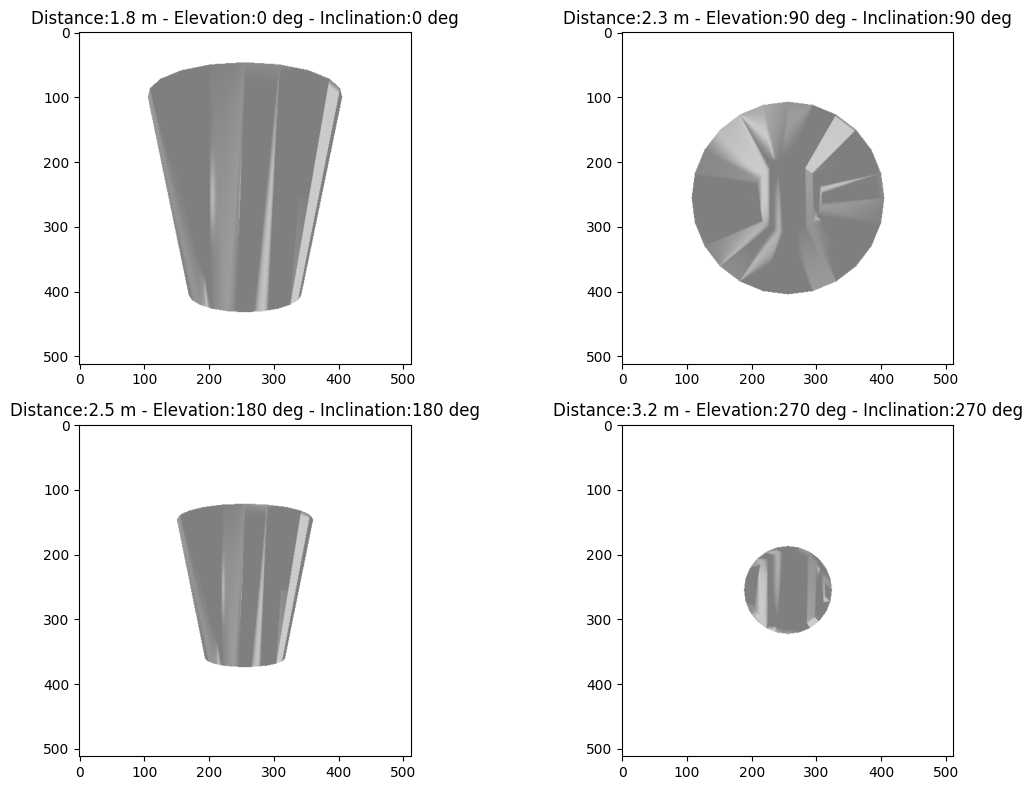

In [76]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(rendered_images_[i][0, ..., :3].detach().cpu().numpy())
    ax.set_title(f"Distance:{distances_[i]} m - Elevation:{elevations_[i]} deg - Inclination:{angles_[i]} deg")

plt.tight_layout()
plt.show()

## 2D augmentation
This step let have more views of the stylized mesh in order to have more comparison with the ground thruth when the loss has to be computed.

In [61]:
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(1, 1)),
    transforms.RandomPerspective(fill=1, p=0.8, distortion_scale=0.5)
])

In [62]:
def augmentation2D(rendered_images):
  augmented_images = [] # array with augmented images

  for rendered_image in rendered_images:
    augmented_image = augment_transform(rendered_image[0, ..., :4].permute(2, 0, 1))
    augmented_images.append(augmented_image)

  return augmented_images

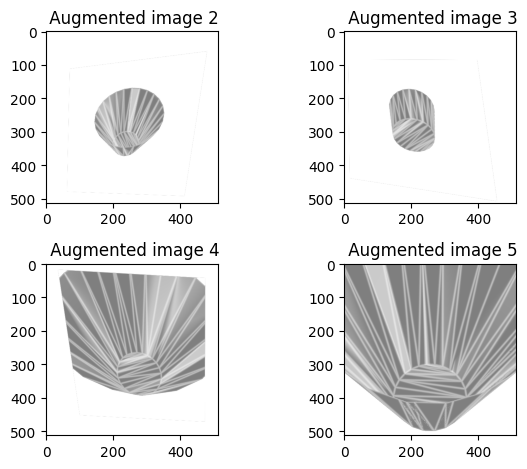

In [63]:
augmented_images = augmentation2D(rendered_images_)

plt.subplot(2, 2, 1)

i  = 0
for augmented_image in augmented_images:
  plt.subplot(2, 2, i + 1)
  i += 1
  plt.imshow(augmented_image.detach().cpu().permute(1, 2, 0))  # Convert back to (H, W, C) for display
  plt.title(f" Augmented image {i + 1}")

plt.tight_layout()
plt.show()

# Loss
To compare the input 2D guidance with the rendered deformed shape is important to select an apporpiate loss.

In [77]:
guid_mesh_idx = 1
guid_mesh_path = meshes_paths[guid_mesh_idx]
guid_mesh = meshes[guid_mesh_idx]

mesh_fig = mesh_visualization(guid_mesh_path)
mesh_fig.show()

100%|██████████| 4/4 [00:00<00:00, 25.96it/s]


[LOG] Computing render for distance 1.8, elevation 0, angle 0
[LOG] Computing render for distance 2.3, elevation 90, angle 90
[LOG] Computing render for distance 2.5, elevation 180, angle 180
[LOG] Computing render for distance 3.2, elevation 270, angle 270


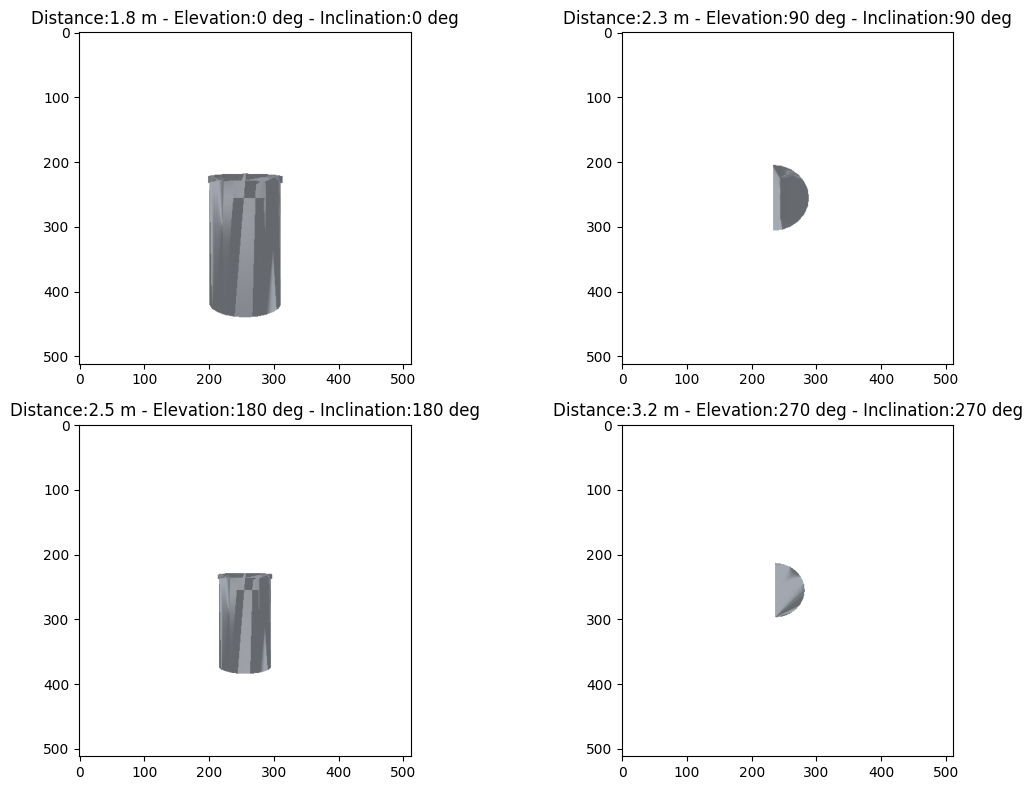

In [80]:
guid_distances, guid_elevations, guid_angles, guid_rendered_images = differentiable_renderer(guid_mesh,device)

fig, ax = plt.subplots(2,2,figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(guid_rendered_images[i][0, ..., :3].detach().cpu().numpy())
    ax.set_title(f"Distance:{guid_distances[i]} m - Elevation:{guid_elevations[i]} deg - Inclination:{guid_angles[i]} deg")

plt.tight_layout()
plt.show()

In [85]:
loss = 0.0
for i in range(global_var['rendered_items']):
    loss += F.binary_cross_entropy_with_logits(guid_rendered_images[i], rendered_images_[i])

print(f"[LOG] Loss: {loss:.4f}")

[LOG] Loss: 1.8937


# Train

## Input
Mesh to be deformed + 2D guidances

In [92]:
input_mesh = get_mesh(meshes_paths[9]) # Cono
guidances_2d = guid_rendered_images # Mezzo cilindro

# Network
Neural Style Field

In [88]:
model = NeuralStyleField(
    verts_dim = global_var['verts_dim'],
    hidden_dim = global_var['hidden_dim'],
    depth = global_var['emb_net_depth'],
    disp_dim = global_var['disp_dim'],
    disp_depth = global_var['disp_net_depth'],
    norm_ratio = global_var['norm_ratio'],
    debug = False)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.02)
iters = 20
losses = []

## Train

In [118]:
with trange(iters,desc="Train", unit="", position=0, leave=True) as pbar:
    for iter in pbar:
        model.train()

        # Inputs
        inputs = input_mesh.verts_list()[0].to(device)
        targets = guidances_2d

        # Network output
        outputs = model(inputs)

        # Update mesh
        input_mesh.offset_verts_(input_mesh.verts_list()[0]+input_mesh.verts_normals_list()[0]*outputs)

        # Rendering
        _,_,_,rendered_mesh = differentiable_renderer(input_mesh,device,debug=False)

        # Loss
        loss = 0.0
        for i in range(global_var['rendered_items']):
            loss += criterion(targets[i].to(device), rendered_mesh[i].to(device))
        loss /= global_var['rendered_items']

        # Backpropagation
        optimizer.zero_grad()
        torch.autograd.set_detect_anomaly(True)
        # loss.backward(retain_graph=True)
        optimizer.step()

        # Log
        pbar.set_postfix(loss=loss.item())
        losses.append(loss.item())

Train: 100%|██████████| 20/20 [00:13<00:00,  1.46/s, loss=0.165]
